In [1]:
#%matplotlib inline
from matplotlib import style
from matplotlib.pyplot import figure
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, and_

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)


In [7]:
# We can view all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind = engine)

In [10]:
# Take a look what's in side...
inspector = inspect(engine)

tables = inspector.get_table_names()

for table in tables:
    print('\033[1m' + 'TABLE NAME: ' + table + '\033[0m')
    columns = inspector.get_columns(table)
    for column in columns:
        print('\033[95m' + column["name"] + '\033[0m', column["type"])

TABLE NAME: measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
TABLE NAME: station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Take a look the date column
date_col = session.query(Measurement.date).\
                    group_by(Measurement.date).\
                    order_by(Measurement.date).all()

num_days = len(date_col)

print(f'There are {num_days} days in the Mesurement table.')
print(f'The FIRST avaiable date is : {date_col[0][0]}')
print(f'The LAST avaiable date is : {date_col[num_days -1][0]}')

There are 2792 days in the Mesurement table.
The FIRST avaiable date is : 2010-01-01
The LAST avaiable date is : 2017-08-23


In [12]:
# Take a look the station column
station_col = session.query(Measurement.station).\
                    group_by(Measurement.station).\
                    order_by(Measurement.station).all()

num_station = len(station_col)

print(f'There are {num_station} stations in the Mesurement table.')

There are 9 stations in the Mesurement table.


In [13]:
# What are the stations names?
station_name = session.query(Station.name).distinct().all()

station_name

[('WAIKIKI 717.2, HI US'),
 ('KANEOHE 838.1, HI US'),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('PEARL CITY, HI US'),
 ('UPPER WAHIAWA 874.3, HI US'),
 ('WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('WAIHEE 837.5, HI US'),
 ('HONOLULU OBSERVATORY 702.2, HI US'),
 ('MANOA LYON ARBO 785.2, HI US')]

# Exploratory Climate Analysis

Last observation date:  2017-08-23 00:00:00
One year ago date:  2016-08-22 00:00:00


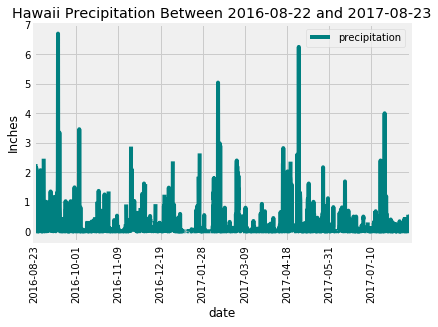

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
## Find the last obveration date
last_date = date_col[num_days -1][0]

## Convert string to datetime object
last_date = dt.datetime.strptime(last_date, '%Y-%m-%d')

## Find a year ago
a_year_ago = last_date - dt.timedelta(days = 366)
print('Last observation date: ', last_date)
print('One year ago date: ', a_year_ago)

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).\
                    filter(and_(Measurement.date >= a_year_ago, Measurement.date < last_date)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_data = pd.DataFrame(prcp_data, columns = ['date', 'precipitation'])

## Sort df by date
prcp_data = prcp_data.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
prcp_data.plot(kind = 'line', x = 'date', y = 'precipitation', color = 'teal')
plt.title('Hawaii Precipitation Between ' + a_year_ago.strftime('%Y-%m-%d') + ' and ' + last_date.strftime('%Y-%m-%d'))
plt.ylabel('Inches')
plt.xticks(rotation='vertical');

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_data['precipitation'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

In [16]:
# Design a query to show how many stations are available in this dataset?
num_station = session.query(Measurement.station).distinct().count()

print(f"There are {num_station} stations in this dataset")

There are 9 stations in this dataset


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
num_data_by_station = session.query(Station.name, Measurement.station, func.count(Measurement.prcp)).\
                                filter(Measurement.station == Station.station).\
                                group_by(Measurement.station).\
                                order_by(func.count(Measurement.tobs).desc()).all()

num_data_by_station_df = pd.DataFrame(num_data_by_station, columns = ['Station_Name', 'Station_ID', 'Number_of_Measurement'])

num_data_by_station_df


,Station_Name,Station_ID,Number_of_Measurement
0,"WAIHEE 837.5, HI US",USC00519281,2772
1,"WAIKIKI 717.2, HI US",USC00519397,2685
2,"KANEOHE 838.1, HI US",USC00513117,2696
3,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,2572
4,"MANOA LYON ARBO 785.2, HI US",USC00516128,2484
5,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,1937
6,"HONOLULU OBSERVATORY 702.2, HI US",USC00511918,1932
7,"PEARL CITY, HI US",USC00517948,683
8,"UPPER WAHIAWA 874.3, HI US",USC00518838,342


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_name = num_data_by_station_df.iloc[num_data_by_station_df['Number_of_Measurement'].idxmax(), 0]
most_active_id = num_data_by_station_df.iloc[num_data_by_station_df['Number_of_Measurement'].idxmax(), 1]

sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

temper_data = session.query(*sel).filter(Measurement.station == most_active_id).all()

low_temp, high_temp, ave_temp = temper_data[0]

print(f'Station {most_active_name} (ID: {most_active_id}) is the most active station.')
print(f'The lowest temperature recorded was {low_temp}F.')
print(f'The highest temperature recorded was {high_temp}F.')
print(f'The average temperature was {round(ave_temp, 2)}F.')

Station WAIHEE 837.5, HI US (ID: USC00519281) is the most active station.
The lowest temperature recorded was 54.0F.
The highest temperature recorded was 85.0F.
The average temperature was 71.66F.


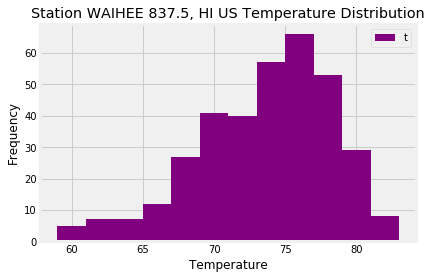

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_last12m = session.query(Measurement.date, Measurement.tobs).\
                            filter(Measurement.station == most_active_id).\
                            filter(and_(Measurement.date > a_year_ago, Measurement.date < last_date)).all()

most_active_last12m_df = pd.DataFrame(most_active_last12m, columns = ['date', 'temperature'])

most_active_last12m_df['temperature'].hist(bins = 12, color = 'purple')
plt.title(f'Station {most_active_name} Temperature Distribution')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend('tobs', loc = 'upper right');


## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2015-05-01'
end_date   = '2015-05-31'
trip_temp  = calc_temps(start_date, end_date)

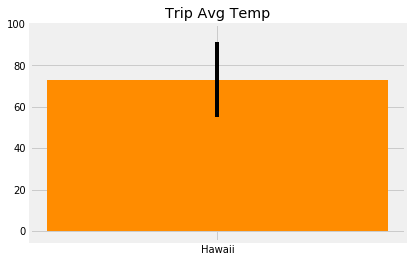

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar('Hawaii', trip_temp[0][1], yerr = (trip_temp[0][2] - trip_temp[0][0]), color = 'darkorange')
plt.ylim(-5, 100)
plt.title('Trip Avg Temp');

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
pre_year_start_date = str(int(start_date[0:4])-1) + '-' + start_date[5:]
pre_year_end_date   = str(int(start_date[0:4])-1) + '-' + end_date[5:]

sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

pre_year_prcp = session.query(*sel).\
                        filter(and_(Measurement.date >= pre_year_start_date, Measurement.date < pre_year_end_date)).\
                        filter(Measurement.station == Station.station).\
                        group_by(Station.station).\
                        order_by(func.sum(Measurement.prcp).desc()).all()

pre_year_prcp_df = pd.DataFrame(pre_year_prcp, columns = ['station_id', 'name', 'lat', 'lng', 'elevation', 'total_prcp'])

pre_year_prcp_df

,station_id,name,lat,lng,elevation,total_prcp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,10.19
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,6.74
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,4.64
3,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,2.07
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,2.05
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.86
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,1.69
7,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,1.02


In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = dt.datetime(2015, 5, 1)
end_date   = dt.datetime(2015, 5, 31)

day_delta =  end_date - start_date

# Loop through the list of %m-%d strings and calculate the normals for each date

hist_data_dict = {
    'Date':[],
    'tmin':[],
    'tavg':[],
    'tmax':[]
}

for i in range(day_delta.days + 1):
    hist_date = start_date + dt.timedelta(days = i)
    output = daily_normals(hist_date.strftime("%m-%d"))
    
    hist_data_dict['Date'].append(hist_date.strftime("%Y-%m-%d"))
    hist_data_dict['tmin'].append(output[0][0])
    hist_data_dict['tavg'].append(output[0][1])
    hist_data_dict['tmax'].append(output[0][2])


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
hist_temp_df = pd.DataFrame(hist_data_dict)
hist_temp_df = hist_temp_df.set_index('Date', drop = True)
hist_temp_df.head()

,tmin,tavg,tmax
Date,,,
2015-05-01,65.0,72.759259,79.0
2015-05-02,65.0,73.050847,79.0
2015-05-03,67.0,73.410714,84.0
2015-05-04,65.0,73.596491,78.0
2015-05-05,67.0,73.396552,79.0


<Figure size 720x7200 with 0 Axes>

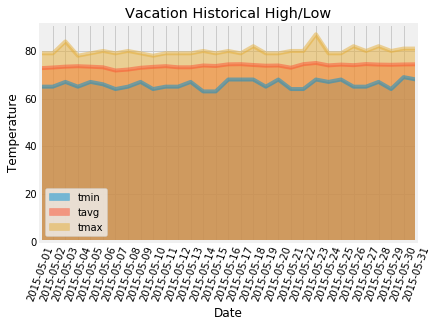

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
figure(figsize=(10,100))
hist_temp_df.plot.area(stacked=False)
plt.xticks(np.arange(31), hist_temp_df.index, rotation = 70)
plt.title('Vacation Historical High/Low')
plt.ylabel('Temperature')
plt.xlabel('Date');